**Library Imports**

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import cv2 
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, Dropout 
from keras.models import Model 
from tensorflow.keras.layers import BatchNormalization 
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 
from keras.datasets import cifar10 
from tensorflow.keras.utils import plot_model 
from keras import backend as K 
import pandas as pd
import torch


Defining the RGB to Gray **Function**

In [2]:
#Using cv2.cvtcolor(image, cv2.color_scheme) 
#Input coloured image and returned the gray image 
def rgb_gray(img): 
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  return gray_img


**Loading Data**

In [3]:
#Loading the training and testing dataset from Keras datasets 
#Here, x_train is our training set and x_test is our validation set 
#We do not require the y_train/y_test dataset as we are not performing image classification with target labels 
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
#Dimensions of each of the sets 
print(x_train.shape) 
print(x_test.shape) 
#Getting the height, width and number of channels from the image 
img_dim = x_train.shape[1] 
channels = 3


170508288/170498071 [==============================] - 14s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


**Displaying Sample Images from the dataset with their respective class**

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


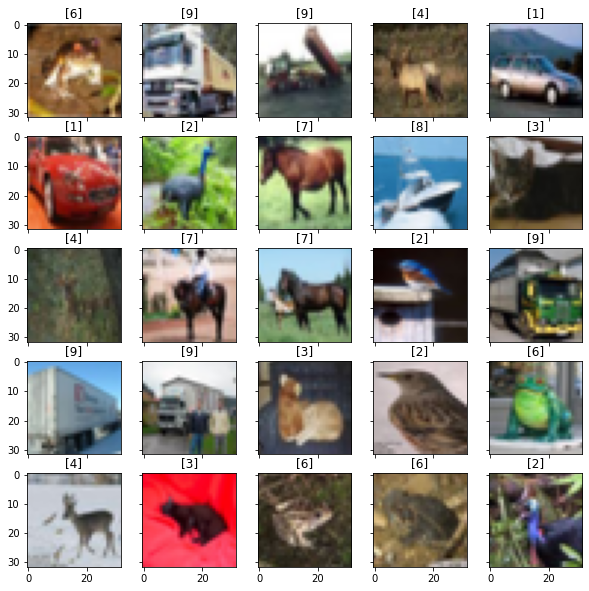

In [4]:
#Display sample images from the dataset 
fig, ax = plt.subplots(5,5,sharex=True,sharey=True,figsize=(10,10)) 
c=0 
for i in range(0,5): 
  for j in range (0,5): 
    ax[i,j].imshow(x_train[c]) 
    ax[i,j].set_title(y_train[c]) 
    c=c+1


**Conversion process and sorting them in a list**

In [5]:
#Our lists to store the converted images 
x_train_Gray = [] 
x_test_Gray = [] 
#Iterate over number of images for training set 
for i in range(x_train.shape[0]): 
  img = x_train[i] 
#convert and append 
  x_train_Gray.append(rgb_gray(img)) 
print(len(x_train_Gray)) 

50000


In [6]:
#Same process for the test images 
for i in range(x_test.shape[0]): 
  img = x_test[i] 
  x_test_Gray.append(rgb_gray(img)) 
print(len(x_test_Gray)) 

10000


**Image Pre-processing**

In [7]:
#Convert the given list to a numpy array for input 
x_train_Gray = np.asarray(x_train_Gray) 
x_test_Gray = np.asarray(x_test_Gray) 
#Reshape the given data into (m, height, width, channels) 
#We will reshape both the training coloured and gray images - Features and targets 
x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, channels) 
x_test = x_test.reshape(x_test.shape[0], img_dim, img_dim, channels) 
x_train_Gray = x_train_Gray.reshape(x_train_Gray.shape[0], img_dim, 
img_dim, 1) 
x_test_Gray = x_test_Gray.reshape(x_test_Gray.shape[0], img_dim,img_dim,1) 
input_shape = (img_dim, img_dim, 1) 
lat_dim = 256


**Normalizing pixels over the range [0-1]**

In [8]:
#Dividing each pixel by 255 to get a normalized value 
x_train = x_train.astype('float32')/255 
x_test = x_test.astype('float32')/255 
x_train_Gray = x_train_Gray.astype('float32')/255 
x_test_Gray = x_test_Gray.astype('float32')/255 

**Example of Sample Image and Converted Image (After passing through black and white function)**

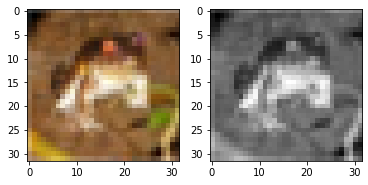

In [9]:
im1 = x_train[0] 
fig, ax = plt.subplots(ncols = 2) 
ax[0].imshow(im1) 
im2 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY) 
ax[1].imshow(im2, cmap='gray') 

**Initialisation of the encoder model**

In [10]:
#ENCODER MODEL 
inputs = Input(shape=input_shape, name='encoder_input') 
x = inputs 
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x) 
x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x) 
x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x) 
shape = K.int_shape(x) 
x = Flatten()(x) 
latent = Dense(lat_dim, name='latent_vector')(x) 
encoder = Model(inputs, latent, name='encoder_model') 
encoder.summary() 

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
N

**Initialisation of the dencoder model**

In [11]:
#DECODER MODEL 
latent_inputs = Input(shape = (lat_dim,), name = 'decoder_input') 
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs) 
x = Reshape((shape[1], shape[2], shape[3]))(x) 
x = Conv2DTranspose(256, (3,3), strides = 2, activation = 'relu', padding= 'same')(x) 
x = Conv2DTranspose(128, (3,3), strides = 2, activation = 'relu', padding= 'same')(x) 
x = Conv2DTranspose(64, (3,3), strides = 2, activation = 'relu', padding ='same')(x) 
outputs = Conv2DTranspose(3, (3,3), activation = 'sigmoid', padding = 'same', name = 'decoder_output')(x) 
decoder = Model(latent_inputs, outputs, name = 'decoder_model') 
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 64)     

**Auto-encoder model**

In [12]:
#AUTOENCODER MODEL 
autoencoder = Model(inputs, decoder(encoder(inputs)), name = 'autoencoder') 
autoencoder.summary() 

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder_model (Functional)  (None, 256)               1418496   
                                                                 
 decoder_model (Functional)  (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


**Learning Rate Scheduling and Checkpoint Callbacks**

In [13]:
#Learning Rate plateau and scheduling 
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1), cooldown = 0, patience = 5, verbose = 1, min_lr = 0.5e-6) 
#Preparing save location during model training 
save_dir = os.path.join(os.getcwd(), 'saved_models') 
model_name = 'colorized_ae_model.h5' 
#Creating dir to save the model 
if not os.path.isdir(save_dir): 
  os.makedirs(save_dir) 
filepath = os.path.join(save_dir, model_name) 
print(filepath) 
#Checkpoint and learning rate scheduling callback 
checkpoints = ModelCheckpoint(filepath = filepath, monitor = 'val_loss', verbose = 1, save_best_only = True) 
callbacks = [lr_reducer, checkpoints] 

/content/saved_models/colorized_ae_model.h5


**Training the model over the given dataset over batches and epochs**

In [16]:
#TRAINING 
#Using the desired loss function, optimizer and metric 
autoencoder.compile(loss = "mse", optimizer = 'Adam', metrics = ['accuracy']) 
#Fit the model with the training set and validation set 
history=autoencoder.fit(x_train_Gray, x_train, validation_data = (x_test_Gray, x_test),epochs = 50, batch_size = 16, callbacks = callbacks) 
x_decoded = autoencoder.predict(x_test_Gray) 
autoencoder.save('colourization_model.h5')

Epoch 1/50
3122/3125 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.4965
Epoch 1: val_loss improved from 0.01288 to 0.00952, saving model to /content/saved_models/colorized_ae_model.h5
3125/3125 [==============================] - 23s 7ms/step - loss: 0.0110 - accuracy: 0.4966 - val_loss: 0.0095 - val_accuracy: 0.5191 - lr: 0.0010
Epoch 2/50
3122/3125 [============================>.] - ETA: 0s - loss: 0.0093 - accuracy: 0.5059
Epoch 2: val_loss improved from 0.00952 to 0.00881, saving model to /content/saved_models/colorized_ae_model.h5
3125/3125 [==============================] - 21s 7ms/step - loss: 0.0093 - accuracy: 0.5058 - val_loss: 0.0088 - val_accuracy: 0.5179 - lr: 0.0010
Epoch 3/50
3124/3125 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.5143
Epoch 3: val_loss improved from 0.00881 to 0.00824, saving model to /content/saved_models/colorized_ae_model.h5
3125/3125 [==============================] - 22s 7ms/step - loss: 0.0086 - a

**Loading the Model and checking out the results**

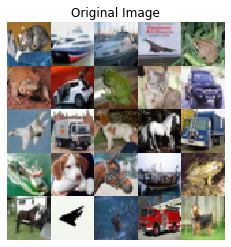

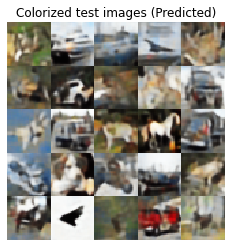

In [17]:
from google.colab import files 
#files.download('colourization_model.h5') 
#Displaying Results 
imgs = x_test[:25] 
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels)) 
imgs = np.vstack([np.hstack(i) for i in imgs]) 
plt.figure() 
plt.axis('off') 
plt.title('Original Image') 
plt.imshow(imgs, interpolation='none') 
#plt.savefig('%s/colorized.png' % imgs_dir) 
plt.show() 
imgs = x_decoded[:25] 
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels)) 
imgs = np.vstack([np.hstack(i) for i in imgs]) 
plt.figure() 
plt.axis('off') 
plt.title('Colorized test images (Predicted)') 
plt.imshow(imgs, interpolation='none') 
#plt.savefig('%s/colorized.png' % imgs_dir) 
plt.show()

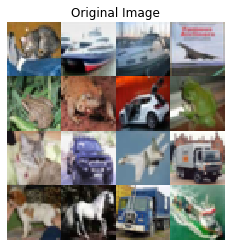

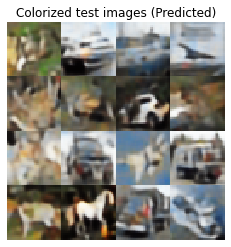

In [21]:
from google.colab import files 
#files.download('colourization_model.h5') 
#Displaying Results 
imgs = x_test[:16] 
imgs = imgs.reshape((4, 4, img_dim, img_dim, channels)) 
imgs = np.vstack([np.hstack(i) for i in imgs]) 
plt.figure() 
plt.axis('off') 
plt.title('Original Image') 
plt.imshow(imgs, interpolation='none') 
#plt.savefig('%s/colorized.png' % imgs_dir) 
plt.show() 
imgs = x_decoded[:16] 
imgs = imgs.reshape((4, 4, img_dim, img_dim, channels)) 
imgs = np.vstack([np.hstack(i) for i in imgs]) 
plt.figure() 
plt.axis('off') 
plt.title('Colorized test images (Predicted)') 
plt.imshow(imgs, interpolation='none') 
#plt.savefig('%s/colorized.png' % imgs_dir) 
plt.show()

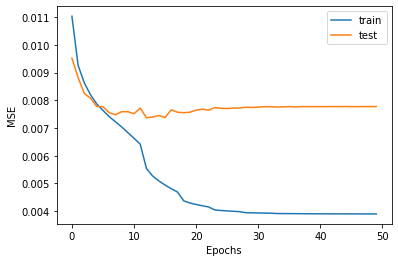

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()
#plt.imshow(x_decoded[2])

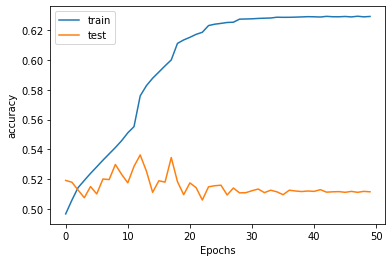

In [19]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.show()
#plt.imshow(x_decoded[2])

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'